# Combining Pairs Trading and Simple Volume-Based Momentum - Will Friend

## Introduction

This notebook looks to implement the pairs trading strategy from *Pairs_Trading.ipynb*, and to supplement it with a simple volume-based momentum strategy involving cryptocurrency historical data downloaded from Binance using the Binance python API. We download nearly four years of data from January of 2021 through the end of Q3 2024, and define the formation period as Q1 2021 - Q3 2022, and our trading period as Q4 2022 - Q3 2024.

### Pairs Trading

Pairs trading is a subset of statistical arbitrage, where one uses statistical tools to identify co-moving asset (assets that, while may be on different orders of trading price, or volume, tend to move with each other). When a pair has been identified, one looks for deviations from there mean spread (or a break in the co-movement). 

Say we have two assets that are deemed highly correlated and co-move, asset A and B, where A is priced higher than B. One day, we see that asset A has jumped (lowered) in price, while asset B has lowered (increased) in price. This breaks the co-movement, as the spread between the two stocks is now x amount greater (less) than the mean spread seem when co-moving. 

This increase (decrease) in the spread relative to the mean is the signal pairs trading seeks to capitalize on. The strategy relies around the correlation of the stocks and the assumption that any deviation from there co-movement will always revert back to the mean (ie any increases or decreases from the mean will always eventually return to the stable state). A simple strategy is to track the movement of the stocks and their spread, and to enter a position when the spread deviates from the mean:
- if asset A increases (decreases) and asset B decreases (increases) at time t, we would enter a short (long) position with asset A and a long (short) position for assset B.
- We would exit our positions once the assets have returned to their steady state in their spread (or clos enough using a threshold defined by the trader).

### Momentum Trading

Momentum strategies attempt to identify signals indicating that a trend in an asset is going to continue (has momentum). A simple case of momemtum is that if a company's earning reports are released and they have beat the expectation set by forecastors/analysts, we expect that the price of the asset will increase, and we might expect that the rise of this asset may continue for a period of time, indicating that it might be a good asset to buy after the report comes out. 

Traders are often seeking to capitalize on trends already existing in the market. If there is strong performance in META, we might expect that assets in its bin (tech assets) might experience a similar increase in performance due to momentum rising in outlook in tech. It is often described as a tide affect, where "a rising tide lifts all boats". 

The same is true for lower performing stocks -- if an asset underperforms in its earning reports, one might expect a prolonged period of underperformance, which might affect similarly binned assets.

Momentum is often talked about with its antithesis, reversal, which essentially looks for signals that might indicate a weaker performing stock is going to rebound.

In this notebook, we seek to capture both reversal and momentum affects using a volume-based indicator.

## Python Implementation

### Packages

We being by importing the necessary python packages to implement the data. We use the Binance API to download relevant historical cryptocurrency k-line data, and use pandas to store the data in readable DataFrames. We import numpy and varying libraries from the statsmodels package to help us carry out the statistical analysis, pandas as the backbone of working with the data, and matplotlib and seaborn to help us visualize the data and analysis:

In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pdb
import warnings 
warnings.filterwarnings('ignore')

client = bnb_client(tld='US')

_dict = client.get_exchange_info()['symbols']


### Creating our Universe

Next using the binance client we create a list of available coin tickers, and filter for those that
1) Are not coins tracking currency
2) Are stable coins under the "Tethered" price index (USDT)

In [2]:
univ = []
for i in _dict:
    if 'USDT' in i['symbol'] and 'USD' not in i['symbol'][0:3]:
        univ.append(i['symbol'])
        
print(f"There are {len(univ)} coins found.")

There are 174 coins found.


From above we see that 174 coins were found. We will want to filter these further but we will need their historical data to do this. Below we define a function to download the historical data of a specific coin at a defined frequency, and store the data in a pandas DataFrame:

In [3]:
def get_binance_px(symbol,freq,start_ts = '2021-01-01', end_ts = '2024-09-30'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

# univ = ['BTCUSDT', 'ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '1d'
px = {}
vol = {}
for x in univ:
    data = get_binance_px(x,freq)
    # pdb.set_trace()
    px[x] = data.set_index('open_time')['close']
    vol[x] = data.set_index('open_time')['volume']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()
vol = pd.DataFrame(vol).astype(float)
vol = vol.reindex(pd.date_range(vol.index[0],vol.index[-1],freq=freq))

We downloaded data at a frequency of one day, and saved the closing price and the volume for each coin in their own data frame. We then calculated the return data based on teh closing price DataFrame.

### Data Processing

For our pairs trading strategy, since we implement a rebalance/re-evaluation period for the pairs being traded on, we will continue to allow coins to enter and exist the market to be traded on.

For our momentum strategy, we will filter our coins so that any coins that either entered or exited the market during our period of interest are dropped from our dataset:

In [4]:
px_adj = px.dropna(axis=1)
vol_adj = vol[px_adj.columns]
form_px = px_adj.loc["2021-01-01":"2022-09-30"]
px_adj

,BTCUSDT,ETHUSDT,BCHUSDT,LTCUSDT,BNBUSDT,ADAUSDT,BATUSDT,ETCUSDT,XLMUSDT,ZRXUSDT,...,MKRUSDT,ONEUSDT,BANDUSDT,STORJUSDT,UNIUSDT,SOLUSDT,EGLDUSDT,PAXGUSDT,OXTUSDT,ZENUSDT
2021-01-01,29305.29,728.52,341.28,126.19,37.6696,0.17488,0.2043,5.6515,0.13170,0.3738,...,581.14,0.00425,5.4899,0.2945,4.7488,1.8455,26.049,1948.03,0.2300,11.813
2021-01-02,32162.01,774.56,353.76,136.99,38.2207,0.17726,0.2037,5.7741,0.12758,0.3613,...,608.64,0.00428,6.0015,0.2922,4.8595,1.7955,25.935,1984.98,0.2343,11.674
2021-01-03,33031.74,978.14,422.97,160.86,41.1282,0.20624,0.2172,6.5539,0.13634,0.3907,...,678.57,0.00491,6.7898,0.3154,5.5152,2.1682,27.167,1954.21,0.2295,13.328
2021-01-04,32005.27,1042.10,404.44,155.55,41.0884,0.22533,0.2185,7.0553,0.16407,0.3923,...,685.71,0.00491,6.7136,0.2982,5.4310,2.4924,30.639,2005.48,0.2320,13.292
2021-01-05,33946.09,1100.22,418.34,158.13,41.8000,0.25913,0.2312,7.2447,0.19408,0.4450,...,764.03,0.00499,7.4138,0.3169,6.2500,2.1561,33.889,2029.10,0.2585,14.241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,65051.65,2632.69,349.80,68.51,596.5000,0.40080,0.1947,20.2000,0.09800,0.3529,...,1615.00,0.01440,1.2930,0.4384,7.2620,155.2300,29.550,2662.00,0.0786,8.520
2024-09-27,65785.70,2695.00,359.40,71.20,607.1000,0.40140,0.1942,20.8400,0.09860,0.3694,...,1716.00,0.01507,1.3450,0.4410,7.6160,157.7700,30.260,2645.00,0.0785,8.800
2024-09-28,65908.11,2675.60,352.60,69.96,599.9000,0.40020,0.1923,20.5000,0.09960,0.3553,...,1683.00,0.01444,1.3040,0.4250,7.5690,156.7100,29.070,2638.00,0.0791,8.590
2024-09-29,65670.63,2657.77,351.40,69.38,595.7000,0.39640,0.1901,20.2400,0.10160,0.3623,...,1651.00,0.01460,1.3100,0.4334,7.4200,158.3900,29.420,2662.00,0.0788,8.480


After applying our filtering criteria we are left with 29 coins to conduct our analysis on.

### Strategy Implementation

Now that we have data, we will look to write code to carry out the formation and trading of the two strategies. We begin by defining the same **Utils** class as seen in the *pairs_trading.ipynb* notebook, which contains methods for determining performance of the strategy as well as methods for weighting one strategy against another. The latter will determine how we weight the pairs trading strategy against the momentum strategy.

In [5]:
import binance
import numpy as np
import os
import pandas as pd


class Utils:
    
    def __init__(self, save_portf: str=os.getcwd()) -> None:
        
        self.save_portf = save_portf
        
    def get_binance_px(self, client: binance.client.Client, symbol: str, freq: str, start_ts: str='2021-01-01', end_ts: str='2023-12-31') -> pd.DataFrame:
        
        from datetime import datetime
        
        data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
        columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

        data = pd.DataFrame(data,columns = columns)

        # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
        data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
        data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
        
        return data 
        
    def turnover(self, portf: pd.DataFrame) -> pd.Series:

        to = (portf.fillna(0) - portf.shift().fillna(0)).abs().sum(axis=1)

        return to

    def ann_sharpe(self, ret: pd.DataFrame) -> float:
        
        avg_ret = ret.mean()
        vol_ret = ret.std()
        sr = avg_ret / vol_ret * np.sqrt(365)

        return sr
    
    def optimal_weights(self, sigma: pd.DataFrame, mu: float) -> pd.Series:
        
        try:
            wgt = np.linalg.inv(sigma) @ mu 
            wgt = wgt / np.abs(wgt).sum()  
            
        except np.linalg.LinAlgError as err:
            sigma_value = sigma.iloc[0,0]
            sigma = np.diag(np.full(sigma.shape[0],sigma_value))
            wgt = np.linalg.inv(sigma) @ mu 
            wgt = wgt / np.abs(wgt).sum()

        return wgt

    def eqvol_weights(self, sigma: pd.DataFrame) -> pd.Series:
        
        wgt = 1/np.sqrt(np.diag(sigma))
        wgt = wgt / np.abs(wgt).sum()
        
        return wgt

    def sr_weights(self, sigma: pd.DataFrame, mu: float) -> pd.Series:
        
        wgt = mu / np.diag(sigma) 
        wgt = wgt / np.abs(wgt).sum()
        
        return wgt
    
    def save_portfolio(self, portf: pd.DataFrame) -> None:
        
        portf.to_pickle(self.save_portf)
        
        print(f"Dataframe saved to {self.save_porft}")
        
    def drawdown(self, returns):
        # Calculate cumulative returns
        cumulative = (1 + returns).cumprod()

        # Calculate the running maximum
        running_max = cumulative.cummax()

        # Calculate drawdown
        drawdown = (cumulative - running_max) / running_max

        return drawdown
    
    def duration(self, px):

        peak = px.expanding(min_periods=1).max()
        res = pd.DataFrame(index=px.index,columns=px.columns)

        for col in px.columns:
            for dt in px.index:

                if px.loc[dt,col] >= peak.loc[dt,col]:
                    res.loc[dt,col] = 0

                else:    
                    res.loc[dt,col] = res.loc[:dt,col].iloc[-2] + 1

        return res

Next we will implement the **PairsBacktest** class, which will carry out the formation of tradeable pairs, signal creation, and trading on those signals.

#### Pairs Strategy

To find co-moving pairs, we will use correlation between two assets to determine our traded on pairs. Specifically, if two assets price movement during the trading period show correlation greater than 0.875, they are determined to be a tradeable pair. If a pair enters or exists the universe of coins during a trading period, it will not be considered as a tradeable asset.

Next we will seek to define our trading signals. Specifically, we will look to identify when we will long (short) asset A and short (long) asset B in each of the pairs found in the section above. We want to identify our signal independent of market movement, defined hereout as $\beta$. In other words, we want to find the alpha of our spread between the two spreads, and define our signals based on this alpha. 

We define alpha as follows:
- We have two co-moving time series. Assuming some linear relationship between the two, we can regress asset A against asset B:
    - $A = \alpha + \beta*B + \epsilon$, where $\alpha$ is the regression constant, $\beta$ is the regression slope, and $\epsilon$ is the residual of the regression
- Typically we say that the "purified" signal is the component of $\alpha + \epsilon$. In our analysis, however, we will only be considering the residual component $\epsilon$. 
- In order to understand the change in alpha, we will then transform it using its z-score in order to define signals based off of movements in stadard deviation space

To account for market movement, we will define our z-score by using a rolling average and standard deviation:

$$ 
z = \frac{\epsilon_{t} - \bar{\epsilon}_{t-window}}{\sigma_{t-window}}
$$

We will define our window to be 90 days. We will start with our entry signal being 1.5 STD away from the mean, and our exit signal being when it reverts back to 1.0 STD from the mean.

To correct for possible decorrelation of pairs as the market evolves during the trading period, we will also implement a rebalance period $T_r$, where every $T_r$ days we will exit our positions held, and will find new correlated pairs from the previous $T_r$ days. We define our rebalance period to be every 180 days.

In [6]:
class PairsBacktest:
    
    def __init__(self, window: int=60, entry_signal: float=1, exit_signal: float=0.5) -> None:
        
        self.window = window
        self.entry_signal = entry_signal
        self.exit_signal = exit_signal
        
    def get_pairs(self, px: pd.DataFrame) -> list:
        
        n = px.shape[1]
        pairs = []
        
        for i in range(n):
            for j in range(i+1,n):
                
                tmp1 = np.log(px.iloc[:,i])
                tmp2 = np.log(px.iloc[:,j])
                
                corr = tmp1.corr(tmp2)
                
                if corr >= 0.875:
                    pairs.append((tmp1.name, tmp2.name))
                    
        return pairs
    
    def get_signal(self, px: pd.DataFrame, pairs: list) -> pd.DataFrame:
        
        signals = {}
        
        for pair in pairs:

            X = np.log(px[pair[0]]).fillna(0)
            Y = np.log(px[pair[1]]).fillna(0)
            X = sm.add_constant(X)

            if len(X) < self.window:
                
                reg = RollingOLS(Y,X,window=(len(X)+2),expanding=True).fit()

                alpha = reg.params['const'].fillna(method='bfill')
                beta = reg.params[pair[0]].fillna(method='bfill')

                residual = Y - (X[pair[0]]*beta) - alpha

                z_score = (residual - residual.rolling(window=(len(X)+2),min_periods=1).mean()) / residual.rolling(window=(len(X)+2),min_periods=1).std()

                signals[(pair,"z-score")] = z_score
                signals[(pair,"beta")] = beta
            
            else:
        
                reg = RollingOLS(Y,X,window=self.window,expanding=True).fit()
                
                alpha = reg.params['const'].fillna(method='bfill')
                beta = reg.params[pair[0]].fillna(method='bfill')

                residual = Y - (X[pair[0]]*beta) - alpha

                z_score = (residual - residual.rolling(window=self.window,min_periods=1).mean()) / residual.rolling(window=self.window,min_periods=1).std()
                
                signals[(pair,"z-score")] = z_score

        signals = pd.DataFrame(signals)
        
        return signals
    
    def get_portfolio(self, px: pd.DataFrame, signals: pd.DataFrame, pairs: list) -> pd.DataFrame:
        
        portf = pd.DataFrame(columns=px.columns, index=px.index)
        
        for pair in pairs:
            
            z_score = signals[(pair,"z-score")]
            
            portf.loc[(z_score.fillna(0) > self.entry_signal)&(z_score.shift().fillna(0) < self.entry_signal),pair[0]] = 1
            portf.loc[(z_score.fillna(0) < self.exit_signal)&(z_score.shift().fillna(0) > self.exit_signal),pair[0]] = 0
        
            portf.loc[(z_score.fillna(0) > self.entry_signal)&(z_score.shift().fillna(0) < self.entry_signal),pair[1]] = -1
            portf.loc[(z_score.fillna(0) < self.exit_signal)&(z_score.shift().fillna(0) > self.exit_signal),pair[1]] = 0
            
            portf.loc[(z_score.fillna(0) < -self.entry_signal)&(z_score.shift().fillna(0) > -self.entry_signal),pair[0]] = -1
            portf.loc[(z_score.fillna(0) > -self.exit_signal)&(z_score.shift().fillna(0) < -self.exit_signal),pair[0]] = 0
            
            portf.loc[(z_score.fillna(0) < -self.entry_signal)&(z_score.shift().fillna(0) > -self.entry_signal),pair[1]] = 1
            portf.loc[(z_score.fillna(0) > -self.exit_signal)&(z_score.shift().fillna(0) < -self.exit_signal),pair[1]] = 0
         
        portf = portf.ffill()
        portf = portf.divide(portf.abs().sum(axis=1),axis=0).fillna(0)
        
        return portf
    
    def trade_pairs(self, px: pd.DataFrame, rebalance_dates: list, rebalance_val: int) -> (pd.Series, pd.DataFrame):
        
        utils = Utils()
        
        net_ret = pd.Series(index=px.index,name="Pairs Trading")
        net_ret = net_ret.loc[rebalance_dates[1]:]
        
        num_pairs = pd.Series(index=px.index,name="Number of Pairs")
        
        for ii in range(1,len(rebalance_dates)):
            
            if ii == len(rebalance_dates)-1:
                form_pairs = px.loc[rebalance_dates[ii-1]:rebalance_dates[ii]-pd.DateOffset(1),:]
                trade_pairs = px.loc[rebalance_dates[ii]:,:]
            else:
                form_pairs = px.loc[rebalance_dates[ii-1]:rebalance_dates[ii]-pd.DateOffset(1),:]
                trade_pairs = px.loc[rebalance_dates[ii]:rebalance_dates[ii+1]-pd.DateOffset(1),:]
            
            pairs = self.get_pairs(form_pairs)
            
            num_pairs.loc[trade_pairs.index] = len(pairs)
            
            signals = self.get_signal(px=trade_pairs, pairs=pairs)
            
            portf = self.get_portfolio(px=trade_pairs,signals=signals,pairs=pairs)
            
            trade_ret = trade_pairs.pct_change().fillna(0)
            strat_ret = (portf.shift() * trade_ret).sum(axis=1)
            
            to = utils.turnover(portf=portf)
            tcost_bps = 20
            net_ret.loc[trade_pairs.index] = strat_ret.subtract(to*tcost_bps*1e-4,fill_value=0)
            
        net_ret = net_ret.fillna(0)
        
        evaluation = {}

        evaluation['Sharpe Ratio'] = utils.ann_sharpe(net_ret)
        evaluation['Avg. Turnover'] = to.mean()
        evaluation['Holding Period'] = 2 / to.mean()
        evaluation['Annual Returns'] = net_ret.mean() * 365
        evaluation['Annual Volatility'] = net_ret.std() * np.sqrt(365)
        evaluation['T-Cost'] = (to*tcost_bps*1e-4).mean()
        evaluation = pd.DataFrame(evaluation, index=[net_ret.name])
        
        return net_ret, evaluation, num_pairs


Below executes the pairs trading strategy with our defined trading criteria with the **PairsBacktest** class:

In [7]:
window = 90
entry_signal = 1.5
exit_signal = 1.0
rebalance=180

start_rebalance = px.index.get_loc(form_px.index[-1]-pd.DateOffset(rebalance-1))

rebalance_dates = px.iloc[start_rebalance::rebalance].index
trade_px = px.loc[rebalance_dates[0]:,:]

btp = PairsBacktest(window=window,entry_signal=entry_signal,exit_signal=exit_signal)

net_ret_pairs, evaluation_pairs, num_pairs = btp.trade_pairs(px=trade_px,rebalance_dates=rebalance_dates,rebalance_val=rebalance)

Next we will implement the **MomentumBacktest** class, which will carry out the formation of signal creation, and trading on those signals for momentum.

#### Momentum Strategy

It has been shown through various literature that an assets volume can used as a possible indicator of momentum/reversal. We will attempt to capture four different scenarios relating asset volume to its current price:

1) If an asset's volume increases and it has positive returns, we expect positive momentum (the asset's upward return trajectory to continue)
2) If an asset's volume increases and it has negative returns, we expect negative momentum (the asset's downward return trajectory to continue)
3) If an asset's volume decreases and it has positive returns, we expect negative reversal (the asset will turn from positive to negative returns)
4) If an asset's volume decreases and it has negative returns, we expect positive reversal (the asset will turn from negative to positive returns)

We will use the rolling z-score of the volume as an indicator of changes in volume, and the same day returns to determine proper sign of the weight assigned to the asset. Defined below is the formula to get the volume signal:

$$
w_{i,t} = \frac{V_{i,t}-\bar{V}_{i,t-T}}{\sigma_{i,t-T}},
$$

where *T* is the lookback window in our rolling z-score. Using $w_{i,t}$ we will multiply by $R_{i,t}$ to get the correct sign of the portfolio weight based on the four scenario's above:

1) $w_{i,t} > 0$ and $R_{i,t} > 0$ &rarr; $W_{portf} > 0$
    - Positive portfolio weight for positive momentum
2) $w_{i,t} > 0$ and $R_{i,t} < 0$ &rarr; $W_{portf} < 0$
    - Negative portfolio weight for negative momentum
3) $w_{i,t} < 0$ and $R_{i,t} > 0$ &rarr; $W_{portf} < 0$
    - Negative portfolio weight for negative reversal
4) $w_{i,t} < 0$ and $R_{i,t} < 0$ &rarr; $W_{portf} > 0$
    - Positive portfolio weight for positive reversal
    
where $W_{portf}$ is the portfolio weight value. After getting the portfolio weights, they are demeaned and normalized in order to attempt to separate out any market influence (to achieve alpha).

Below is a python class to carry out the signal generation and trading of the strategy:

In [8]:
class MomentumBacktest:
    
    def __init__(self):
        
        pass

    def calc_vol_portf(self, rets: pd.DataFrame, vol: pd.DataFrame, window: int) -> pd.DataFrame:
        weights = (vol - vol.ewm(span=window).mean()) / vol.ewm(span=window).std() * rets
        # weights = (vol / vol.shift().rolling(window=window,min_periods=1).mean())
        portf = weights.subtract(weights.mean(axis=1),axis=0)
        portf = portf.divide(portf.abs().sum(axis=1),axis=0)
        return portf

    def get_portfolio(self, rets: pd.DataFrame, weights: pd.DataFrame) -> pd.DataFrame:
        strat_ret = (rets.shift() * weights).sum(axis=1)
        return strat_ret
    
    def trade_momentum(self, ret: pd.DataFrame, vol: pd.DataFrame, window: int) -> (pd.Series, pd.DataFrame):
        
        utils = Utils()
        
        portf = self.calc_vol_portf(rets=ret, vol=vol, window=window)
        strat_ret = self.get_portfolio(rets=ret, weights=portf)
        # strat_ret = portf.sum(axis=1)

        to = utils.turnover(portf=portf)
        tcost_bps = 20 # (comissions + slip)
        net_ret = strat_ret.subtract(to*tcost_bps*1e-4,fill_value=0)
        net_ret.name = "Momentum"

        evaluation = {}

        evaluation['Sharpe Ratio'] = utils.ann_sharpe(net_ret)
        evaluation['Avg. Turnover'] = to.mean()
        evaluation['Holding Period'] = 2 / to.mean()
        evaluation['Annual Returns'] = net_ret.mean() * 365
        evaluation['Annual Volatility'] = net_ret.std() * np.sqrt(365)
        evaluation['T-Cost'] = (to*tcost_bps*1e-4).mean()
        evaluation = pd.DataFrame(evaluation,index=[net_ret.name])     
        
        return net_ret, evaluation
        
        

In [9]:
mbt = MomentumBacktest()

trade_mom = px_adj.loc[rebalance_dates[1]:,:].pct_change()

vol_mom = vol_adj.loc[trade_mom.index]

net_ret_mom, evaluation_mom = mbt.trade_momentum(ret=trade_mom,vol=vol_mom,window=5)


## Strategy Comparison

Let's quickly look at the performance of the two stratgies:

In [10]:
evaluation = pd.concat([evaluation_pairs,evaluation_mom],axis=0)
evaluation


,Sharpe Ratio,Avg. Turnover,Holding Period,Annual Returns,Annual Volatility,T-Cost
Pairs Trading,3.374667,1.284177,1.557418,1.276705,0.378320,0.002568
Momentum,1.485704,1.447480,1.381712,0.425940,0.286692,0.002895


Looking at the summary of the two strategies, we see that the pairs trading strategy has a strong Sharpe (\~3.37) compared to the already strong Sharpe (\~1.48) of the momentum strategy. This is not entirely surprising since we have many more positions in our pairs trading strategy compared to our momentum strategy. We see a stronger return in the pairs trading strategy than the momentum strategy, but a higher volatility as well.

To visualize the difference of performance, we will plot the cummulative returns of each over the trading period:

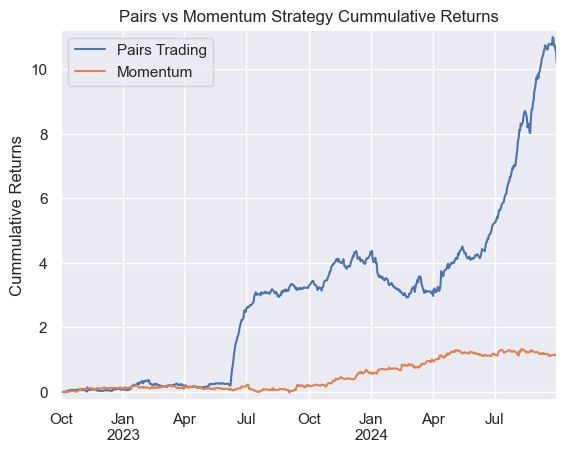

In [11]:
combined = {}
combined[net_ret_pairs.name] = net_ret_pairs
combined[net_ret_mom.name] = net_ret_mom
combined = pd.DataFrame(combined)

_ = ((1+combined).cumprod() - 1).plot()
_ = plt.ylabel("Cummulative Returns")
_ = plt.title("Pairs vs Momentum Strategy Cummulative Returns")
plt.margins(0.02)



Finally, as a sanity check against our pairs trading performance, we will plot the number of coins in the market over the trading window, and the number of pairs traded on over the trading periods:

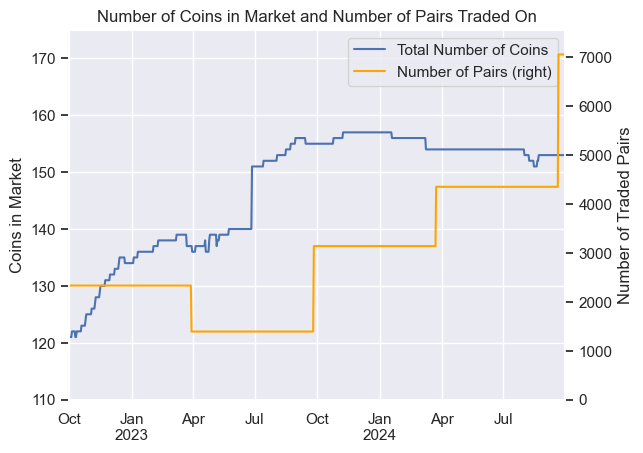

In [12]:
fig, ax = plt.subplots()

ax = (len(px.columns) - px.loc[net_ret_pairs.index].isnull().sum(axis=1)).plot(label="Total Number of Coins")
ax.set_ylabel("Coins in Market")
ax.set_ylim([110,175])

ax2 = ax.twinx()
ax2 = num_pairs.loc[net_ret_pairs.index].plot(secondary_y=True,label="Number of Pairs",color='orange')
ax2.set_ylabel("Number of Traded Pairs")
ax2.set_ylim([0,np.max(num_pairs)+500])

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [l.get_label() for l in lines])
plt.margins(0.02)
plt.grid(False)
_ = plt.title("Number of Coins in Market and Number of Pairs Traded On")
plt.show()

The plot above confirms that there is not a situation where one coin would be traded on, or that one signular pair was being traded on.

## Combining the Two Strategies

Next we will investigate supplementing one strategy with the other in a combined portfolio. We will use the **Utils** class to calculate three different weighting schema for the two strategies, and compare it to a simple 50:50 split in weighting the strategies. 

### Weighting Schema

The three different portfolio weighting conventions we will calculate are: 1) optimal weighting, 2) equal volatility weighting, and 3) Sharpe Ratio weighting.

- Optimal weighting assumes that all bets in a portfolio have equal Sharpes and equal volatility, and looks optimize your investment strategy based on these assumptions.
- Equal volatility weighting seeks to optmize the investment in each strategy proportionally to each strategies contribution to the overall portfolio volatility. It relaxes the assumption that all bets' volatility are the same.
- Sharpe Ratio weighting relaxes the assumption that all bets in a portfolio have the same Sharpe Ratio, and seeks to up-weight the strategies that have higher Sharpe values.

To calculate all of these, the covariance of the strategies (referred to as $\Sigma$), and the average returns of each strategy (referred to as $\mu$) are what are needed. The correlation matrix can be defined as followed:

$$
\Sigma = \left [
\begin{matrix}
\sigma_{1}^{2} & \rho_{1,2}\sigma_{1}\sigma_{2} & \rho_{1,3}\sigma_{1}\sigma_{3} \\
\rho_{1,2}\sigma_{1}\sigma_{2} & \sigma_{2}^{2} & \rho_{2,3}\sigma_{2}\sigma_{3} \\
\rho_{1,3}\sigma_{1}\sigma_{3} & \rho_{2,3}\sigma_{2}\sigma_{3} & \sigma_{3}^{2}
\end{matrix}
\right ] \tag{3-3}
$$

where $\sigma_{i}$ is the volatility of strategy *i* and $\rho_{i,j}$ is the correlation between strategy *i, j*. The formula for the weights (in order of definition) are:

$$
W_{opt} = \Sigma^{-1}\mu,
$$

$$
W_{vol} = \frac{1}{\sqrt{diag(\Sigma)}},
$$

$$
W_{SR} = \frac{\mu}{diag(\Sigma)},
$$

For ensuring a fully invested portfolio, are weights are calculated they are normalized such that the sum of each weight of strategies is equal to 1.

Below is code to weight the two strategies, accounting for the rebalance period for the pairs trading strategy. We assume change in $\mu$ are significant over shorter (relative to the rebalance period) time horizons, and account for its changes every 15-days (approximately two weeks, however 180 is divisible by 15 and thus it was chosen to make computation easier/more efficient). We assume that changes in $\Sigma$ are negligible, and adjust it at each rebalance date using the just completed trading period data.

In [13]:
utils = Utils()

combo_rets = pd.DataFrame(columns=['50:50','opt','eqvol','sr'], index=combined.index)

sigma = combined.rolling(window=rebalance,min_periods=1).cov().fillna(1)
mu = combined.rolling(window=5,min_periods=1).mean().fillna(1)

weekly_dates = trade_px.index[rebalance::15]

mu = combined.mean() * 0 + 1
sigma = combined.cov() * 0 + 1

weights_tot = pd.DataFrame(
    columns=[
        ['Pairs','Pairs','Pairs','Pairs','Momentum','Momentum','Momentum','Momentum'],
        ['opt','eqvol','sr','50:50','opt','eqvol','sr','50:50']
    ],
    index=combo_rets.index
)

count = 1

for ii in range(1,len(weekly_dates)):
    
    weights = {}
    weights['opt'] = utils.optimal_weights(sigma,mu)
    weights['eqvol'] = utils.eqvol_weights(sigma)
    weights['sr'] = utils.sr_weights(sigma,mu)
    weights['50:50'] = (weights['opt'] / weights['opt']) / combined.shape[1]
    
    weights = pd.DataFrame(weights)
        
    weights_tot.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1), 'Pairs'] = weights.loc['Pairs Trading'].values
    weights_tot.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1), 'Momentum'] = weights.loc['Momentum'].values
    
    combo_rets.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),'50:50'] = (combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:] * weights['50:50']).sum(axis=1)
    combo_rets.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),'opt'] = (combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:] * weights['opt']).sum(axis=1)
    combo_rets.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),'eqvol'] = (combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:] * weights['eqvol']).sum(axis=1)
    combo_rets.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),'sr'] = (combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:] * weights['sr']).sum(axis=1)
        
    mu = combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:].mean()
    
    if weekly_dates[ii] in rebalance_dates:
        sigma = combined.loc[rebalance_dates[count]:rebalance_dates[count+1]-pd.DateOffset(1),:].cov()
        count += 1
    
combo_rets = combo_rets.fillna(0)

<Figure size 640x480 with 0 Axes>

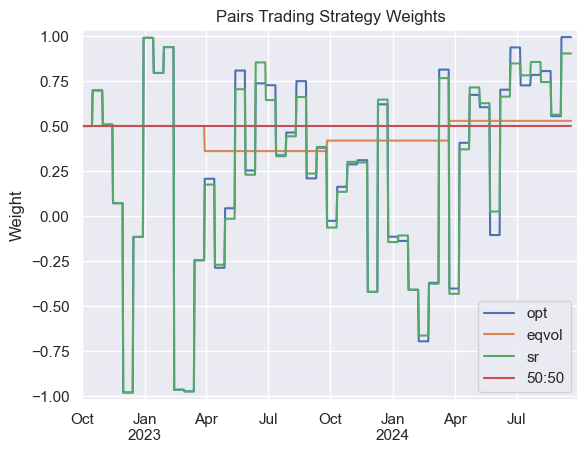

<Figure size 640x480 with 0 Axes>

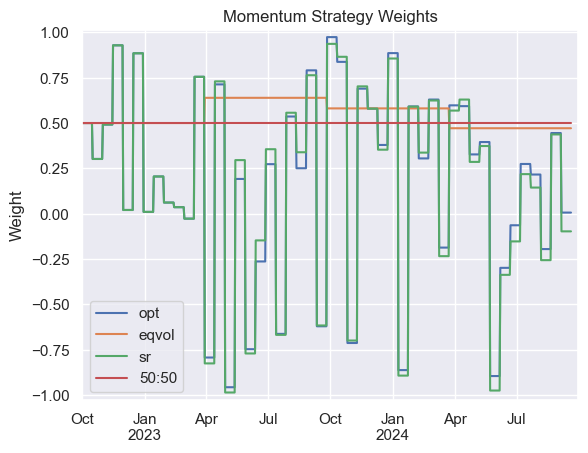

In [14]:
plt.figure()
_ = weights_tot['Pairs'].plot()
_ = plt.ylabel("Weight")
_ = plt.title("Pairs Trading Strategy Weights")
plt.margins(0.02)

plt.figure()
_ = weights_tot['Momentum'].plot()
_ = plt.ylabel("Weight")
_ = plt.title("Momentum Strategy Weights")
plt.margins(0.02)

Above is a plot of the weights fo the strategies over the trading period for pairs strategy (top plot) and the momentum strategy (bottom plot).

With the different weighting schema, lets look at:

1) The Sharpe of the combination
2) The annualized returns
3) The Annualized volatility

We will also plot the cummulative returns of each of the combinations.

,Sharpe Ratio,Ann. Returns,Ann. Volatility
50:50,3.704022,0.856936,0.231353
opt,2.627254,0.678022,0.258072
eqvol,3.535886,0.805111,0.227697
sr,2.620799,0.689078,0.262927


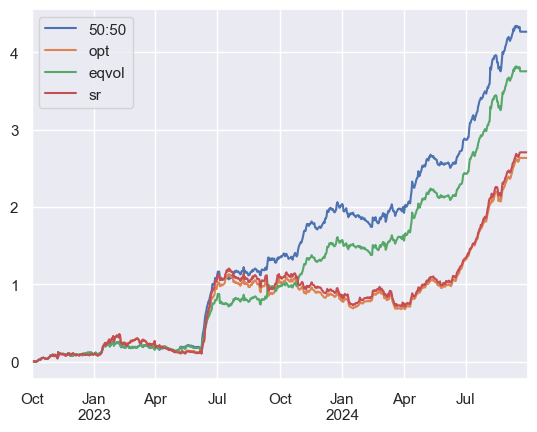

In [15]:
((1+combo_rets).cumprod() - 1).plot()
combo_sr = {}
combo_sr["Sharpe Ratio"] = combo_rets.mean() / combo_rets.std() * np.sqrt(365)
combo_sr["Ann. Returns"] = combo_rets.mean() * 365
combo_sr["Ann. Volatility"] = combo_rets.std() * np.sqrt(365)
combo_sr = pd.DataFrame(combo_sr)
combo_sr

From above, we see that the 50:50 weighting as well as the equal volatility schema have significantly higher performance than the optimal and Sharpe ratio weighting schema, each achieveing Sharpe's greater than the pairs trading Sharpe of ~3.37. While their annualized returns are less than the pairs trading's (85.9% and 80.8% compared to 127.6%), their annualized volatilities are much lower than the pairs trading volatility alone (23.2% and 22.8% compared to 37.8%).

The Sharpe ratio and opitmal weighting schema have significant dependence on the period at which we choose to adjust $\mu$. With longer windows typically creating better performance. Using longer windows, however, might not accurately capture the movement of the market generally, so we will not seek to optimize our window for $\mu$ as it may well be that it will perform poorly for future trading windows.

## Comparing to BTC Buy & Hold

We will take the equal volatility weighting schema and compare it to a simple buy-and-hold strategy with BTC. Similar to how the S&P 500 is used as a proxy to the general market, we will consider the buy-and-hold strategy as a proxy to the cryptocurrency market and use it to assess how our strategy does compared to the market (in both performance and in achieving alpha).

### Drawdown 

We will first look at the drawdown of the three strategies. Drawdown is a metric that measures how far below the prior peak your portfolio is. Accompanying the drawdown are two metrics typically used to summarize your drawdown performance: the maximum drawdown and the maximum drawdown duration. The maximum drawdown tells you the furthest you deviated from a peak, while the maximum drawdown duration tells you the longest period that you spent below a previous peak. Two function are defined in the **Utils** class above to give us the drawdown and drawdown duration. From the two function outputs we can get the maximum drawdown value and the maximum drawdown duration value.

In [16]:
BH = pd.DataFrame(trade_px['BTCUSDT'].pct_change().fillna(0))
BH = BH.iloc[rebalance:,:]
port_bh = pd.Series(np.ones(len(BH)),index=BH.index,name=BH.columns[0])

In [17]:
to_BH = utils.turnover(pd.DataFrame(port_bh))
to_BH.name = port_bh.name
strat_ret_BH = (port_bh.to_frame().shift() * BH)
tcost_bps = 20 # (comissions + slip)
net_ret_BH = strat_ret_BH['BTCUSDT'].subtract(to_BH*tcost_bps*1e-4,fill_value=0)

In [18]:
ret_metrics = {}
ret_metrics['Pairs+Momentum'] = combo_rets['eqvol']
# ret_metrics['Pairs+Momentum'] = net_ret_pairs

ret_metrics['B&H'] = net_ret_BH
ret_metrics = pd.DataFrame(ret_metrics)

Max Pairs+Momentum Trading Drawdown: 9.89%
Max Buy-and-Hold BTC Drawdown: 26.12%


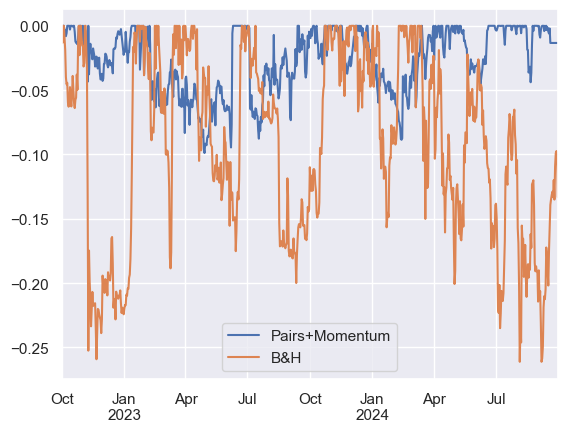

In [19]:
dd = utils.drawdown(ret_metrics)
_ = dd.plot()
print(f"Max Pairs+Momentum Trading Drawdown: {round(abs(dd['Pairs+Momentum'].min())*100,2)}%")
print(f"Max Buy-and-Hold BTC Drawdown: {round(abs(dd['B&H'].min())*100,2)}%")

Max Drawdown Duration for Pairs+Momentum Trading: 122 days
Max Drawdown Duration for Buy-and-Hold BTC: 201 days


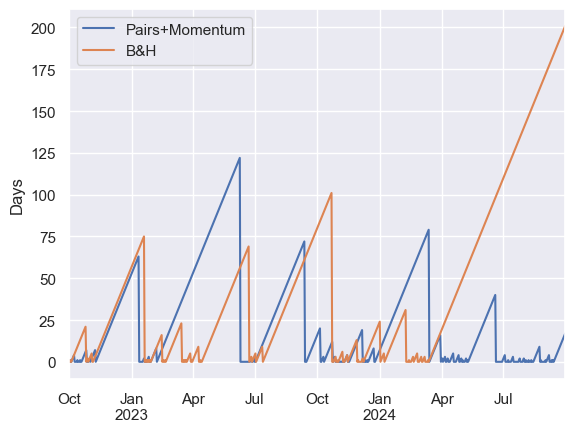

In [20]:
ddd = utils.duration(dd.fillna(0))
_ = ddd.plot()
_ = plt.ylabel("Days")
print(f"Max Drawdown Duration for Pairs+Momentum Trading: {max(ddd['Pairs+Momentum'])} days")
print(f"Max Drawdown Duration for Buy-and-Hold BTC: {max(ddd['B&H'])} days")

From above we can see that the combined strategy's drawdown is on average significantly lower than the buy-and-hold strategy's, with its maximum being 9.89% compared to 26.12%, suggesting that there are less drastic drops in performance between portfolio highs comared to the buy-and-hold.

From the drawdown duration plot, we can see that the strategy partially follows the buy-and-hold strategy's drawdown duration, with longer periods of weaker performance occuring during weak performances of BTC. We see, though, that the maximum drawdown duration of 122 days is less than the BTC 201 day duration. We see that this long duration for BTC continues into the end of our trading period, while our strategy is able to achieve increased performance through this period. This suggests our strategy's independence from market trends (this will be discussed further in the next section).

We will now look at the cummulative returns and performance metrics of the two strategies:

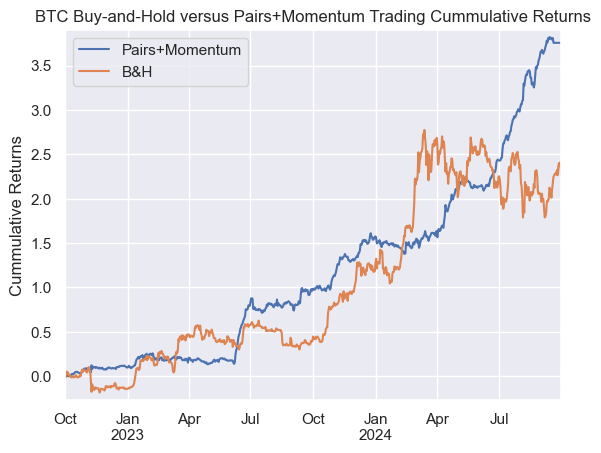

In [21]:
_ = ((1+ret_metrics).cumprod()-1).plot(title="BTC Buy-and-Hold versus Pairs+Momentum Trading Cummulative Returns")
_ = plt.ylabel("Cummulative Returns")
plt.margins(0.02)

In [22]:
combo_rets_eval = {}
combo_rets_eval['Ann. Rets'] = ret_metrics.mean() * 365
combo_rets_eval['Ann. Vol'] = ret_metrics.std() * np.sqrt(365)
combo_rets_eval['Ann. SR'] = combo_rets_eval['Ann. Rets'] / combo_rets_eval['Ann. Vol']
combo_rets_eval = pd.DataFrame(combo_rets_eval)
combo_rets_eval

,Ann. Rets,Ann. Vol,Ann. SR
Pairs+Momentum,0.805111,0.227697,3.535886
B&H,0.710445,0.487912,1.456091


Above we see from the cummulative returns plot that our combined strategy out-performs the buy-and-hold strategy, and shows positive performance during periods where BTC may be underperforming, suggesting our success in isolating our signals from the general trends in the market. 

The buy-and-hold strategy generates a strong Sharpe of ~1.45 during the trading period, with annualized returns of 71.0% and a volatility of 48.8%. Our combined strategy, however, is able to achieve a Sharpe of ~3.53 with annualized earnings ~9% higher at 80.5%, and a ~26% decrease in volatility at 22.8%.

## Generating Alpha

We have seen that our strategy is performing well, but how much of it is simply from trading multiple assets and capturing market trends? Let us now investigate our ability to purify our strategy from general market trends and generate true alpha.

We will once again look at BTC as our proxy to the movement of the market. To assess how well our strategy separates itself from the market, we will regress our strategies returns against BTC returns and see how correlated our strategy is to the regression parameters. We will start by defining a general linear regression equation -- we say the regression of Y against X linearly goes as:

$$
Y = \beta{X}+ \alpha + \epsilon,
$$

where $\beta$ is the regression coefficient, $\alpha$ is the regression constant, and $\epsilon$ is the residual of the regression (the deviation from truth using the best fitted $\beta$ and $\alpha$).

To assess how well our strategy is pruified from the market, we will define our pruified strategy by rearrange the equation above:

$$
\alpha_{t}+\epsilon_{t}=R^{Strat}_{t}-\beta{R^{BTC}_{t}}.
$$

Above, $R_{strat}$ is our strategies returns and takes the place of $Y$ in the regression equation, and $R_{BTC}$ (BTC returns) is what we are regressing our strategies returns against and replaces $X$ in the regression equation. The subscript $t$ indicates that it is a regression at each time point $t$ (for our case $t$ is a day).

We will say our strategy is successfully generating alpha if we see high correlation (or contribution to) between $\alpha+\epsilon$ and $R_{strat}$, and low contribution (or contribution to) between $\beta{R_{BTC}}$ and $R_{strat}$. Below is the code to implement the analysis:

Alpha: 0.002179804708771569
Alpha Volatility: 0.011913335702046444


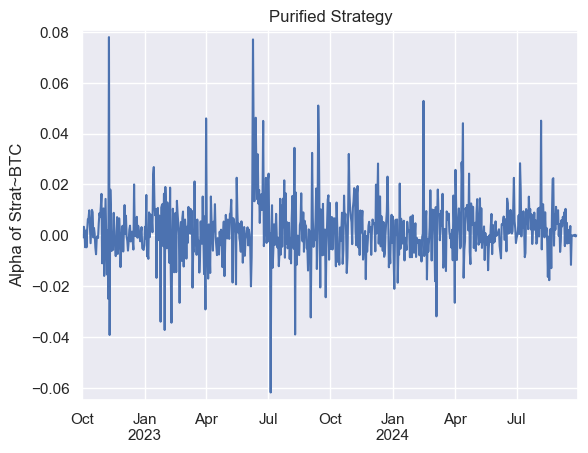

In [23]:
R_BTC = ret_metrics['B&H']
R_BTC = sm.add_constant(R_BTC)

R_Strat = ret_metrics['Pairs+Momentum']

# pdb.set_trace()

model = sm.OLS(R_Strat.astype(float), R_BTC)
results = model.fit()

alpha = results.params.values[0]
beta = results.params.values[1]
resid = results.resid

alpha_contr = alpha+resid
beta_contr = beta * R_BTC['B&H']

_ = alpha_contr.plot(title="Purified Strategy")
_ = plt.ylabel("Alpha of Strat~BTC")
plt.margins(0.02)

print(f"Alpha: {alpha_contr.mean()}")
print(f"Alpha Volatility: {alpha_contr.std()}")

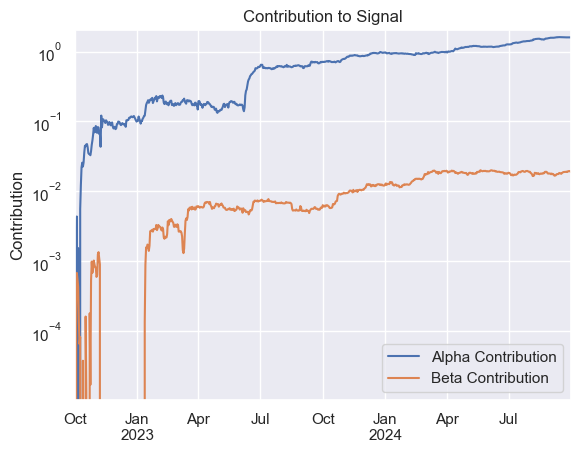

In [24]:
contribution = {}
contribution['Alpha Contribution'] = alpha_contr
contribution['Beta Contribution'] = beta_contr
contribution = pd.DataFrame(contribution)
_ = contribution.cumsum().plot(logy=True, title='Contribution to Signal')
_ = plt.ylabel("Contribution")
plt.margins(0.02)

The plot above shows the contribution of our alpha over time to our strategy (blue) and the contribution of our beta (orange) to our strategy. We can see that the contribution of alpha is consistently $~10^{2}$ greater than the contribution of the beta signal. Additionally we can see that the beta contribution on the order of $10^{-2}$ or less, further showing its low contribution to the strategy.

Looking at the correlation of the beta and alpha to both our strategies returns and BTC returns:

In [25]:
print(f"Correlation of Alpha to Pairs+Momentum Strategy: {alpha_contr.corr(R_Strat.astype(float))}")
print(f"Correlation of Alpha to BTC: {alpha_contr.corr(R_BTC['B&H'])}")
print(f"Correlation of Beta to Pairs+Momentum Strategy: {beta_contr.corr(R_Strat.astype(float))}")
print(f"Correlation of Beta to BTC: {beta_contr.corr(R_BTC['B&H'])}")

Correlation of Alpha to Pairs+Momentum Strategy: 0.9995909397087136
Correlation of Alpha to BTC: -4.2957736982796216e-17
Correlation of Beta to Pairs+Momentum Strategy: 0.028599882032106855
Correlation of Beta to BTC: 1.0


We can see that our alpha is almost perfectly positively correlated with our strategies returns, while the correlation to beta is nearly 0 (~0.03). The results are indicating that we have successfully purified our strategy from the market, and are generating alpha.

### Information Ratio

Finally, we can look at the *Information Ratio* of our strategy's alpha.

The information Ratio is the Sharpe Ratio Equivalent for alpha. It acts as a measure of returns generated beyond the movement of the market. Its definition is similar to that of the Sharpe Ratio:

$$
Information\ Ratio = \frac{\bar{alpha}}{\sigma^{alpha}}
$$

where *alpha* is your purified strategy $\alpha + \epsilon$. You are dividing the mean value of your alpha by its standard deviation. The main difference versus the Sharpe Ratio is that the numerator is only the mean alpha, **not** the alpha mius the mean-alpha.

Below we calculate the information ratio:

In [26]:
ir = alpha_contr.mean() / alpha_contr.std() * np.sqrt(365)
print(f"Information Ratio: {ir}")

Information Ratio: 3.495671701727435


The information ratio of our alpha is very strong (~3.49). It is on the same order of our Sharpe ratio, serving as a sanity check and confirmation of our strategies purification and strong generation of alpha.

## Conclusion

In [27]:
summary_stats = {}
summary_stats['Ann. Returns'] = combo_rets_eval.loc['Pairs+Momentum','Ann. Rets']
summary_stats['Ann. Volatility'] = combo_rets_eval.loc['Pairs+Momentum','Ann. Vol']
summary_stats['Ann. Sharpe Ratio'] = combo_rets_eval.loc['Pairs+Momentum','Ann. SR']
summary_stats['Ann. Information Ratio'] = ir

summary_stats = pd.DataFrame(summary_stats, index=['Pairs+Momentum'])
summary_stats

,Ann. Returns,Ann. Volatility,Ann. Sharpe Ratio,Ann. Information Ratio
Pairs+Momentum,0.805111,0.227697,3.535886,3.495672


In this notebook, we implemented two trading strategies across a universe of cryptocurrencies from Q3 2022 to Q3 2024, and analyzed the performance of combining the two strategies against the market proxy of BTC during the trading period. The two strategies implemented and combined under a common portfolio were 1) pairs trading and 2) volume based momentum. 

We implented two python classes to carry out the trading of the two strategies, and explored four different methods of weighting our investment into the two strategies. Deciding on the equal volatility weighting schema, we found that the strategy generated annualized returns of 80.5% and a volatility of 22.7%, giving a strong Sharpe of 3.53. These metrics outperformed our market proxy of a buy-and-hold strategy of BTC, which while generated high returns of 71% (just ~9% lower than our strategy), it had significantly higher volatility (48.8%), resulting in a lower Sharpe of 1.45. 

Finally, we confirmed that our strategy was successfully purified from the general market and generating alpha by regressing our strategy against BTC, finding almost no correlation between the market estimator and our strategy's returns.